# Gender Prediction by Speech Content

In [1]:
import joblib
import re
import string
import numpy as np
import random
import spacy

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import nltk
from nltk.corpus import stopwords

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nlp = spacy.load('de_core_news_sm') 

In [4]:
stop_words = list(set(stopwords.words('german')))

In [6]:
# complement stopword list with custom data-specific stopwords
exclude_tokens = ['kollege', 'kollegin', 'kollegen', 'abgeordneter', 'redner', 'rednerin', 'staatssekretär', 'staatssekretärin', 'minister', 'ministerin', 'bundesminister', 'dame', 'herr', 'heute', 'damen', 'herren', 'damen herren', 'frau', 'präsidentin', 'ge']
stop_words.extend(exclude_tokens)

In [5]:
# load data
df = pd.read_pickle('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/data_topics_revised.pkl')

df.head()

,text,date,legislative_period,speaker_name,speaker_gender,speaker_role,speaker_party,comments,id,speaker_id,speech_length,topic_distribution
0,Sehr geehrter Herr Alterspräsident! So muss ...,2021-10-26,20,Gabriele Katzmarek,female,None,SPD,[(Beifall bei der SPD sowie bei Abgeordneten d...,SP-2021-0,1299,2593,{68: 0.35882655}
1,Herr Präsident! Liebe Kolleginnen und Kolleg...,2021-10-26,20,Stefan Müller,male,None,CDU/CSU,[(Beifall bei der CDU/CSU sowie bei Abgeordnet...,SP-2021-1,4028,3796,{68: 0.46776655}
2,Sehr geehrter Herr Alterspräsident Wolfgang ...,2021-10-26,20,Britta Haßelmann,female,None,BÜNDNIS 90/DIE GRÜNEN,[(Beifall beim BÜNDNIS 90/DIE GRÜNEN und bei d...,SP-2021-2,451,4301,{68: 0.26328164}
3,Sehr geehrter Herr Präsident! Meine lieben K...,2021-10-26,20,Marco Buschmann,male,None,FDP,"[(Jan Korte [DIE LINKE]: Oder Jugendweihe!), (...",SP-2021-3,3083,4555,{}
4,Herr Alterspräsident! Lassen Sie mich zunäch...,2021-10-26,20,Stephan Brandner,male,None,AfD,"[(Beifall bei der AfD), (Beifall bei Abgeordne...",SP-2021-4,4055,5996,{68: 0.3120498}


In [8]:
df["speaker_gender"].value_counts()

speaker_gender
male      743167
female    228097
Name: count, dtype: int64

## Method #1: Undersampling Male Speeches

In [9]:
male_speeches_total = df['speaker_gender'].value_counts().male
female_speeches_total = df['speaker_gender'].value_counts().female

In [10]:
# calculate topic ratios in original data
male_topic_ratios = {}

for topic in np.arange(0, 150):
    filtered_df = df[df['topic_distribution'].apply(lambda topics: topic in topics)]
    male_speeches = filtered_df.groupby('speaker_gender').size().male
    topic_ratio = male_speeches / male_speeches_total
    male_topic_ratios[topic] = topic_ratio

male_topic_ratios

{0: 0.005736261163372431,
 1: 0.003451444964590731,
 2: 0.007904010807799592,
 3: 0.007038794779639031,
 4: 0.003116392412472567,
 5: 0.0018892119806180846,
 6: 0.008447630209629868,
 7: 0.01052253396612067,
 8: 0.01244538576120845,
 9: 0.007341553109866289,
 10: 0.09141417743252862,
 11: 0.001030723915351462,
 12: 0.00847050528346926,
 13: 0.00716258929688751,
 14: 0.003537562889633151,
 15: 0.0014317105038302294,
 16: 0.0016200934648605227,
 17: 0.004498315990887647,
 18: 0.002875531340869549,
 19: 0.0035886954076270877,
 20: 0.002385735642190786,
 21: 0.0019201606099302042,
 22: 0.0015366667249756783,
 23: 0.0014586223554059854,
 24: 0.008325181284960178,
 25: 0.004908721727417929,
 26: 0.003822828516336167,
 27: 0.013593176230914451,
 28: 0.003030274487430147,
 29: 0.021168862449489817,
 30: 0.007741194105766268,
 31: 0.003970843700002826,
 32: 0.0015312843546605272,
 33: 0.0049356335789936855,
 34: 0.0007468038812272343,
 35: 0.001037451878245401,
 36: 0.031115482791889307,
 37: 0

In [11]:
# calculate new speech counts per topic for resampled data
new_speech_counts = {}

for topic, ratio in male_topic_ratios.items():
    new_speech_count = np.round(ratio * female_speeches_total)
    new_speech_counts[topic] = int(new_speech_count)

new_speech_counts

{0: 1308,
 1: 787,
 2: 1803,
 3: 1606,
 4: 711,
 5: 431,
 6: 1927,
 7: 2400,
 8: 2839,
 9: 1675,
 10: 20851,
 11: 235,
 12: 1932,
 13: 1634,
 14: 807,
 15: 327,
 16: 370,
 17: 1026,
 18: 656,
 19: 819,
 20: 544,
 21: 438,
 22: 351,
 23: 333,
 24: 1899,
 25: 1120,
 26: 872,
 27: 3101,
 28: 691,
 29: 4829,
 30: 1766,
 31: 906,
 32: 349,
 33: 1126,
 34: 170,
 35: 237,
 36: 7097,
 37: 2337,
 38: 987,
 39: 108,
 40: 757,
 41: 1038,
 42: 1164,
 43: 242,
 44: 412,
 45: 313,
 46: 682,
 47: 1395,
 48: 1996,
 49: 328,
 50: 4075,
 51: 332,
 52: 2904,
 53: 1622,
 54: 338,
 55: 392,
 56: 5207,
 57: 1262,
 58: 1461,
 59: 517,
 60: 4353,
 61: 7237,
 62: 290,
 63: 4564,
 64: 161,
 65: 407,
 66: 10021,
 67: 1162,
 68: 3408,
 69: 3997,
 70: 199,
 71: 1027,
 72: 955,
 73: 3360,
 74: 978,
 75: 266,
 76: 312,
 77: 4536,
 78: 901,
 79: 2302,
 80: 2592,
 81: 2097,
 82: 2985,
 83: 2078,
 84: 252,
 85: 3860,
 86: 3270,
 87: 934,
 88: 496,
 89: 299,
 90: 362,
 91: 659,
 92: 578,
 93: 248,
 94: 717,
 95: 1259,
 

In [12]:
# assemble reduced male data
reduced_male_df = pd.DataFrame(columns=df.columns)

for topic, count in new_speech_counts.items():
    selected_speeches = df[(df['speaker_gender'] == 'male') & (df['topic_distribution'].apply(lambda topics: topic in topics))].head(count)
    
    reduced_male_df = pd.concat([reduced_male_df, selected_speeches], ignore_index=True)

C:\Users\Ana\AppData\Local\Temp\ipykernel_26360\4180490814.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reduced_male_df = pd.concat([reduced_male_df, selected_speeches], ignore_index=True)


In [19]:
reduced_male_df

,text,date,legislative_period,speaker_name,speaker_gender,speaker_role,speaker_party,comments,id,speaker_id,speech_length,topic_distribution
0,"Meine Damen und Herren! Herr Minister, ich m...",2021-11-11,20,Thomas Ehrhorn,male,None,AfD,"[(Beifall bei Abgeordneten der AfD), (Beifall ...",SP-2021-21,4132,982,{0: 0.22465643}
1,Ich möchte auf Ihre Frage gern antworten. Er...,2021-11-11,20,Olaf Scholz,male,Bundesminister der Finanzen,None,"[(Zuruf von der AfD: Warum?), (Beifall bei der...",SP-2021-22,3440,1951,"{0: 0.42684105, 29: 0.2142375}"
2,Sehr geehrte Frau Präsidentin! Meine Damen u...,2021-11-11,20,Sebastian Münzenmaier,male,None,AfD,[(Dr. Marco Buschmann [FDP]: Das ist Quatsch!)...,SP-2021-26,3961,4231,{0: 0.20533974}
3,"Ja, gerne. – Zunächst mal ist es ja ein Fort...",2021-11-18,20,Johannes Fechner,male,None,SPD,"[(Beifall bei der SPD, dem BÜNDNIS 90/DIE GRÜN...",SP-2021-98,2376,496,"{0: 0.24128607, 130: 0.25529233}"
4,Frau Präsidentin! Meine Damen und Herren! Da...,2021-11-18,20,Martin Sichert,male,None,AfD,[(Beifall bei Abgeordneten der AfD – Widerspru...,SP-2021-104,3216,6208,{0: 0.28747255}
...,...,...,...,...,...,...,...,...,...,...,...,...
261819,"Herr Abgeordneter, ich habe deutlich betont, ...",1971-05-13,6,Herbert Ehrenberg,male,Staatssekretär des Bundesministeriums für Arbe...,SPD,[],SP-1971-229694,2018,295,"{5: 0.24575704, 27: 0.24492292, 149: 0.2524942}"
261821,"Herr Kollege Baier, selbstverständlich respek...",1971-05-14,6,Heinz Westphal,male,Parlamentarischer Staatssekretär beim Bundesmi...,SPD,[],SP-1971-229920,1936,1451,"{61: 0.28843397, 86: 0.26967123, 149: 0.21287826}"
261822,"Herr Kollege Baier, Sie sind Mitglied des Hau...",1971-05-14,6,Heinz Westphal,male,Parlamentarischer Staatssekretär beim Bundesmi...,SPD,[],SP-1971-229923,1936,1164,"{107: 0.28058052, 149: 0.22335199}"
261823,"Herr Staatssekretär, ich verstehe Sie nicht, ...",1971-05-14,6,Fritz Baier,male,NA,CDU,[],SP-1971-229925,1243,475,{149: 0.36631507}


In [14]:
# remove duplicates due to multiple topics in one speech
to_remove = reduced_male_df[reduced_male_df['id'].duplicated() == True].index
reduced_male_df = reduced_male_df.drop(to_remove)

In [15]:
len(reduced_male_df['id'].unique())

200209

### Remove rest difference between male and female speeches

In [22]:
difference_count = df['speaker_gender'].value_counts().female - len(reduced_male_df)
difference_count

27888

In [23]:
female_speeches = df[df['speaker_gender'] == 'female']

In [24]:
fem_indeces = list(female_speeches.index)

In [25]:
samples_to_remove = random.sample(fem_indeces, difference_count)
len(samples_to_remove)

27888

In [26]:
female_speeches = female_speeches.drop(samples_to_remove)

In [27]:
female_speeches

,text,date,legislative_period,speaker_name,speaker_gender,speaker_role,speaker_party,comments,id,speaker_id,speech_length,topic_distribution
0,Sehr geehrter Herr Alterspräsident! So muss ...,2021-10-26,20,Gabriele Katzmarek,female,None,SPD,[(Beifall bei der SPD sowie bei Abgeordneten d...,SP-2021-0,1299,2593,{68: 0.35882655}
2,Sehr geehrter Herr Alterspräsident Wolfgang ...,2021-10-26,20,Britta Haßelmann,female,None,BÜNDNIS 90/DIE GRÜNEN,[(Beifall beim BÜNDNIS 90/DIE GRÜNEN und bei d...,SP-2021-2,451,4301,{68: 0.26328164}
7,"Herr Alterspräsident, vielen Dank. Ich nehme...",2021-10-26,20,Bärbel Bas,female,None,SPD,[(Beifall im ganzen Hause – Abgeordnete aller ...,SP-2021-7,471,89,{68: 0.7516313}
9,"Frau Präsidentin, ich nehme die Wahl sehr ge...",2021-10-26,20,Aydan Özoğuz,female,None,SPD,"[(Beifall bei der SPD, der CDU/CSU, dem BÜNDNI...",SP-2021-9,327,167,"{68: 0.37566105, 115: 0.4293458}"
10,"Ich nehme die Wahl an, bedanke mich auf das ...",2021-10-26,20,Yvonne Magwas,female,None,CDU/CSU,"[(Beifall bei der CDU/CSU, der SPD, dem BÜNDNI...",SP-2021-10,4708,188,{68: 0.38035467}
...,...,...,...,...,...,...,...,...,...,...,...,...
971273,Vielen Dank. – Frau Präsidentin! Meine sehr g...,2021-07-09,19,Gesine Lötzsch,female,None,DIE LINKE,"[(Beifall bei der LINKEN), (Beifall bei der LI...",SP-2021-971273,1442,1703,{29: 0.25471678}
971274,"Ich weise noch einmal darauf hin, dass die Ze...",2021-07-09,19,Petra Pau,female,None,LINKE,[(Beifall beim BÜNDNIS 90/DIE GRÜNEN)],SP-2021-971274,3648,174,"{81: 0.2370022, 85: 0.5163264}"
971275,Sehr geehrte Frau Präsidentin! Meine Damen un...,2021-07-09,19,Britta Haßelmann,female,None,GRUENE,"[(Beifall beim BÜNDNIS 90/DIE GRÜNEN), (Beifal...",SP-2021-971275,451,1593,"{14: 0.25521588, 148: 0.345872}"
971276,Das Wort hat der Kollege Dr. Florian Toncar.,2021-07-09,19,Petra Pau,female,None,LINKE,[(Beifall bei der FDP)],SP-2021-971276,3648,45,{}


### Combine to new resampled dataframe

In [28]:
resampled_data = pd.concat([reduced_male_df, female_speeches], ignore_index=True)

In [32]:
resampled_data.to_pickle('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/data_undersampled.pkl')

## [Method #2: Oversampling Female Speeches]

In [6]:
df["speaker_gender"].value_counts()

speaker_gender
male      743167
female    228097
Name: count, dtype: int64

In [7]:
df_male_speeches = df[df["speaker_gender"] == "male"]
male_speeches_total

743167

In [8]:
df_female_speeches = df[df["speaker_gender"] == "female"]
df_female_speeches

,text,date,legislative_period,speaker_name,speaker_gender,speaker_role,speaker_party,comments,id,speaker_id,speech_length,topic_distribution
0,Sehr geehrter Herr Alterspräsident! So muss ...,2021-10-26,20,Gabriele Katzmarek,female,None,SPD,[(Beifall bei der SPD sowie bei Abgeordneten d...,SP-2021-0,1299,2593,{68: 0.35882655}
2,Sehr geehrter Herr Alterspräsident Wolfgang ...,2021-10-26,20,Britta Haßelmann,female,None,BÜNDNIS 90/DIE GRÜNEN,[(Beifall beim BÜNDNIS 90/DIE GRÜNEN und bei d...,SP-2021-2,451,4301,{68: 0.26328164}
7,"Herr Alterspräsident, vielen Dank. Ich nehme...",2021-10-26,20,Bärbel Bas,female,None,SPD,[(Beifall im ganzen Hause – Abgeordnete aller ...,SP-2021-7,471,89,{68: 0.7516313}
9,"Frau Präsidentin, ich nehme die Wahl sehr ge...",2021-10-26,20,Aydan Özoğuz,female,None,SPD,"[(Beifall bei der SPD, der CDU/CSU, dem BÜNDNI...",SP-2021-9,327,167,"{68: 0.37566105, 115: 0.4293458}"
10,"Ich nehme die Wahl an, bedanke mich auf das ...",2021-10-26,20,Yvonne Magwas,female,None,CDU/CSU,"[(Beifall bei der CDU/CSU, der SPD, dem BÜNDNI...",SP-2021-10,4708,188,{68: 0.38035467}
...,...,...,...,...,...,...,...,...,...,...,...,...
971274,"Ich weise noch einmal darauf hin, dass die Ze...",2021-07-09,19,Petra Pau,female,None,LINKE,[(Beifall beim BÜNDNIS 90/DIE GRÜNEN)],SP-2021-971274,3648,174,"{81: 0.2370022, 85: 0.5163264}"
971275,Sehr geehrte Frau Präsidentin! Meine Damen un...,2021-07-09,19,Britta Haßelmann,female,None,GRUENE,"[(Beifall beim BÜNDNIS 90/DIE GRÜNEN), (Beifal...",SP-2021-971275,451,1593,"{14: 0.25521588, 148: 0.345872}"
971276,Das Wort hat der Kollege Dr. Florian Toncar.,2021-07-09,19,Petra Pau,female,None,LINKE,[(Beifall bei der FDP)],SP-2021-971276,3648,45,{}
971278,"Ich mache darauf aufmerksam, dass in fünf Min...",2021-07-09,19,Petra Pau,female,None,LINKE,[(Beifall bei der SPD und dem BÜNDNIS 90/DIE G...,SP-2021-971278,3648,10017,{52: 0.38018292}


In [20]:
df_female_speeches = df_female_speeches.loc[df_female_speeches.index.repeat(3)]
df_female_speeches

,text,date,legislative_period,speaker_name,speaker_gender,speaker_role,speaker_party,comments,id,speaker_id,speech_length,topic_distribution
0,Sehr geehrter Herr Alterspräsident! So muss ...,2021-10-26,20,Gabriele Katzmarek,female,None,SPD,[(Beifall bei der SPD sowie bei Abgeordneten d...,SP-2021-0,1299,2593,{68: 0.35882655}
0,Sehr geehrter Herr Alterspräsident! So muss ...,2021-10-26,20,Gabriele Katzmarek,female,None,SPD,[(Beifall bei der SPD sowie bei Abgeordneten d...,SP-2021-0,1299,2593,{68: 0.35882655}
0,Sehr geehrter Herr Alterspräsident! So muss ...,2021-10-26,20,Gabriele Katzmarek,female,None,SPD,[(Beifall bei der SPD sowie bei Abgeordneten d...,SP-2021-0,1299,2593,{68: 0.35882655}
2,Sehr geehrter Herr Alterspräsident Wolfgang ...,2021-10-26,20,Britta Haßelmann,female,None,BÜNDNIS 90/DIE GRÜNEN,[(Beifall beim BÜNDNIS 90/DIE GRÜNEN und bei d...,SP-2021-2,451,4301,{68: 0.26328164}
2,Sehr geehrter Herr Alterspräsident Wolfgang ...,2021-10-26,20,Britta Haßelmann,female,None,BÜNDNIS 90/DIE GRÜNEN,[(Beifall beim BÜNDNIS 90/DIE GRÜNEN und bei d...,SP-2021-2,451,4301,{68: 0.26328164}
...,...,...,...,...,...,...,...,...,...,...,...,...
971278,"Ich mache darauf aufmerksam, dass in fünf Min...",2021-07-09,19,Petra Pau,female,None,LINKE,[(Beifall bei der SPD und dem BÜNDNIS 90/DIE G...,SP-2021-971278,3648,10017,{52: 0.38018292}
971278,"Ich mache darauf aufmerksam, dass in fünf Min...",2021-07-09,19,Petra Pau,female,None,LINKE,[(Beifall bei der SPD und dem BÜNDNIS 90/DIE G...,SP-2021-971278,3648,10017,{52: 0.38018292}
971279,Die unterbrochene Sitzung ist wieder eröffnet...,2021-07-09,19,Petra Pau,female,None,LINKE,"[(Beifall), (Beifall), (Beifall), (Beifall), (...",SP-2021-971279,3648,15388,{}
971279,Die unterbrochene Sitzung ist wieder eröffnet...,2021-07-09,19,Petra Pau,female,None,LINKE,"[(Beifall), (Beifall), (Beifall), (Beifall), (...",SP-2021-971279,3648,15388,{}


In [22]:
rest_difference = male_speeches_total - len(df_female_speeches)
rest_difference

58876

In [26]:
samples_to_add = random.sample(fem_indeces, rest_difference)
len(samples_to_add)

58876

In [30]:
for speech_index in samples_to_add:
    selected_speeches = df[df.index == speech_index]
    
    df_female_speeches = pd.concat([df_female_speeches, selected_speeches])

In [33]:
oversampled_data = pd.concat([df_female_speeches, df_male_speeches])

In [36]:
len(oversampled_data)

1486334

In [35]:
oversampled_data.to_pickle('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/data_oversampled.pkl')

## Vectorize and Train Model

In [7]:
undersampled_data = pd.read_pickle('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/data_undersampled.pkl')

In [17]:
undersampled_data = undersampled_data[["speaker_gender", "text"]]
undersampled_data

,speaker_gender,text
0,male,"Meine Damen und Herren! Herr Minister, ich m..."
1,male,Ich möchte auf Ihre Frage gern antworten. Er...
2,male,Sehr geehrte Frau Präsidentin! Meine Damen u...
3,male,"Ja, gerne. – Zunächst mal ist es ja ein Fort..."
4,male,Frau Präsidentin! Meine Damen und Herren! Da...
...,...,...
400413,female,Vielen Dank. – Frau Präsidentin! Meine sehr g...
400414,female,"Ich weise noch einmal darauf hin, dass die Ze..."
400415,female,Sehr geehrte Frau Präsidentin! Meine Damen un...
400416,female,Das Wort hat der Kollege Dr. Florian Toncar.


In [9]:
sample_text = undersampled_data["text"][0]
sample_text

'  Meine Damen und Herren! Herr Minister, ich muss als Erstes voranstellen, dass ich es für sehr bedauerlich halte, dass selbst ein Bundesminister heute nicht mehr die Größe und den Mut hat, eine Zwischenfrage der AfD, die berechtigt ist, zuzulassen. Meine Frage, die Sie vielleicht nicht nur mir, sondern auch der Bevölkerung beantworten sollten, ist folgende: Wir haben ja nun alle gelernt, dass geimpfte Personen eine genauso hohe Virenlast tragen können wie ungeimpfte. Sie haben von der 3-G-Regelung am Arbeitsplatz geredet. Nun erklären Sie doch mal mir und auch der Bevölkerung, welchen Sinn es macht, dass geimpfte Personen nun nicht getestet werden müssen; denn sie können ja andere genauso gut anstecken wie ungeimpfte. Also ist doch die Frage: Warum ist es nicht so, dass entweder alle oder niemand getestet werden muss? Das versteht in der Bevölkerung wirklich niemand. Aber vielleicht können Sie diese Frage beantworten. Danke. Herr Bundesminister, möchten Sie erwidern?'

In [10]:
doc = nlp("Weidel")

In [11]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Weidel PER


In [14]:
# def process_text(text):
#     doc = nlp(text)

#     text = re.sub(
#         f"[{re.escape(string.punctuation)}]", " ", text
#     )

#     tokens = text.split()  # Split text into tokens
#     filtered_tokens = [token for token in tokens if token.isalpha()]  # Filter tokens based on condition

#     for token in filtered_tokens:
#         doc = nlp(token)
#         for ent in doc.ents:
#             if ent.label_ == 'PER':
#                 filtered_tokens.remove(ent.text)

#     processed_text = ' '.join(filtered_tokens)
#     processed_text = str(processed_text).lower()

#     return processed_text

def process_text(text):
    doc = nlp(text)

    filtered_tokens = []

    for token in doc:
        if token.is_alpha and not token.is_punct and token.ent_type_ not in ['PER', 'LOC']:
            filtered_tokens.append(token.text)

    processed_text = ' '.join(filtered_tokens).lower()

    return processed_text

In [15]:
process_text("Meine Damen und Herren! Herr Minister Seehofer, ich muss als Erstes voranstellen Frau Weidel, dass ich es 2012 für sehr bedauerlich halte")

'meine damen und herren herr ich muss als erstes voranstellen frau dass ich es für sehr bedauerlich halte'

In [18]:
undersampled_data["clean_text"] = undersampled_data.text.map(process_text)

In [10]:
undersampled_data.head()

,speaker_gender,text,clean_text
0,male,"Meine Damen und Herren! Herr Minister, ich m...",meine damen und herren herr minister ich muss ...
1,male,Ich möchte auf Ihre Frage gern antworten. Er...,ich möchte auf ihre frage gern antworten erst ...
2,male,Sehr geehrte Frau Präsidentin! Meine Damen u...,sehr geehrte frau präsidentin meine damen und ...
3,male,"Ja, gerne. – Zunächst mal ist es ja ein Fort...",ja gerne – zunächst mal ist es ja ein fortschr...
4,male,Frau Präsidentin! Meine Damen und Herren! Da...,frau präsidentin meine damen und herren dass i...


In [11]:
len(undersampled_data)

400418

In [ ]:
undersampled_data.to_pickle('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/data_undersampled_processed.pkl')

### Train Test Split

In [12]:
df_train, df_test = train_test_split(undersampled_data, test_size=0.20, stratify=undersampled_data.speaker_gender, random_state=0)

d:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [13]:
vec = CountVectorizer(
    ngram_range=(1, 2), # 1, 3 bei undersampling
    stop_words=stop_words,
    min_df=1000, # ignore terms that appear in less than 50 the speeches # 50 bei undersampling
    max_df=0.4 # ignore terms that appear in more than 40% of the speeches # 0.4 bei undersampling
)  

X_train = vec.fit_transform(df_train.clean_text)
X_test = vec.transform(df_test.clean_text)

y_train = df_train.speaker_gender
y_test = df_test.speaker_gender

d:\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['stimmt', 'wer'] not in stop_words.
  warnings.warn(


In [2]:
# import pickle

# # with open('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/x_train.pkl', 'wb') as f:
# #     pickle.dump(X_train, f)

# # with open('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/x_test.pkl', 'wb') as f:
# #     pickle.dump(X_test, f)

# # with open('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/y_train.pkl', 'wb') as f:
# #     pickle.dump(y_train, f)

# # with open('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/y_test.pkl', 'wb') as f:
# #     pickle.dump(y_test, f)

# # load
# with open('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/x_train.pkl', 'rb') as f:
#    X_train = pickle.load(f)

# with open('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/x_test.pkl', 'rb') as f:
#    X_test = pickle.load(f)
    
# with open('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/y_train.pkl', 'rb') as f:
#    y_train = pickle.load(f)

# with open('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/y_test.pkl', 'rb') as f:
#    y_test = pickle.load(f)

In [14]:
X_test

<80084x3941 sparse matrix of type '<class 'numpy.int64'>'
	with 3746109 stored elements in Compressed Sparse Row format>

### Fit Model

In [15]:
log = LogisticRegression()
log.fit(X_train, y_train)


preds = log.predict(X_test)
print(classification_report(y_test, preds))

d:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\anaconda3\L

              precision    recall  f1-score   support

      female       0.79      0.73      0.76     40042
        male       0.75      0.80      0.77     40042

    accuracy                           0.76     80084
   macro avg       0.77      0.76      0.76     80084
weighted avg       0.77      0.76      0.76     80084



In [87]:
# save classifier and vectorizer
joblib.dump(nb, "nb.joblib")
joblib.dump(vec, "vec.joblib")

['vec.joblib']

In [12]:
# load
nb_saved = joblib.load("nb.joblib")
vec_saved = joblib.load("vec.joblib")

In [35]:
log.predict_proba(X_test)

array([[0.93743226, 0.06256774],
       [0.44297475, 0.55702525],
       [0.42702197, 0.57297803],
       ...,
       [0.94727133, 0.05272867],
       [0.67324209, 0.32675791],
       [0.10704433, 0.89295567]])

In [17]:
# test prediction
sample_text = ["Ich möchte Ihnen sagen, dass es schon gut gewesen wäre, wenn Sie ein paar Sätze zu dem haarsträubenden Verfahren – dem Riesendesaster und den zahlreichen Verfassungsverstößen – gesagt hätten, das wesentlich das Bundesfinanzministerium verursacht hat und das eine ratlose und planlose Regierung hinterlassen hat, die alle Hände voll zu tun hatte, die Fehler auszumerzen, die sie selber verursacht hat."]

clean_sample_text = process_text(sample_text)
sample_vec = vec.transform(sample_text)
log.predict(sample_vec)

array(['male'], dtype=object)

## Confusion Matrix

In [17]:
confusion_matrix(y_test.to_numpy(), preds)

array([[29178, 10864],
       [ 7973, 32069]], dtype=int64)

<Axes: >

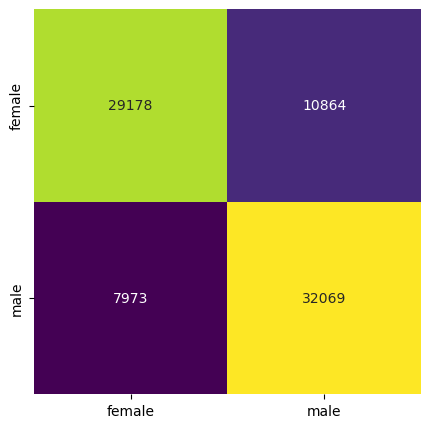

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))

sb.heatmap(confusion_matrix(y_test.to_numpy(), preds),
           annot=True, cmap="viridis", cbar=False,
           fmt="d",
           xticklabels=log.classes_,
           yticklabels=log.classes_)

## Get Important Features

In [36]:
log.classes_

array(['female', 'male'], dtype=object)

In [58]:
len(vec.get_feature_names_out())

3941

In [25]:
print("Important words in female speeches")
print(np.take(vec_saved.get_feature_names_out(), fem_class_prob_sorted[:20]))
print("-----------------------------------------")

print("Important words in male speeches")
print(np.take(vec_saved.get_feature_names_out(), male_class_prob_sorted[:20]))

Important words in female speeches
['dr' 'mehr' 'müssen' 'bundesregierung' 'frau' 'fraktion' 'schon'
 'menschen' 'frage' 'kollegen' 'heute' 'gibt' 'immer' 'ganz' 'sagen' 'ja'
 'kollege' 'wort' 'geht' 'herren']
-----------------------------------------
Important words in male speeches
['herren' 'frage' 'damen' 'damen herren' 'bundesregierung' 'worden'
 'kollege' 'muß' 'sagen' 'bitte' 'müssen' 'dr' 'mehr' 'antrag' 'heute'
 'herr kollege' 'schon' 'ja' 'deutschen' 'wort']


In [19]:
import shap

In [21]:
explainer = shap.Explainer(log, X_train, feature_names=vec.get_feature_names_out())

In [22]:
shap_values = explainer(X_test)

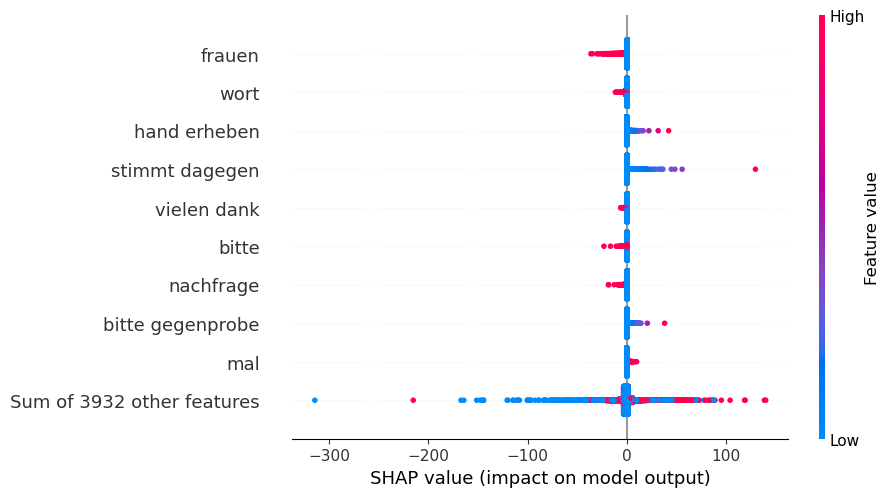

In [23]:
shap.plots.beeswarm(shap_values)

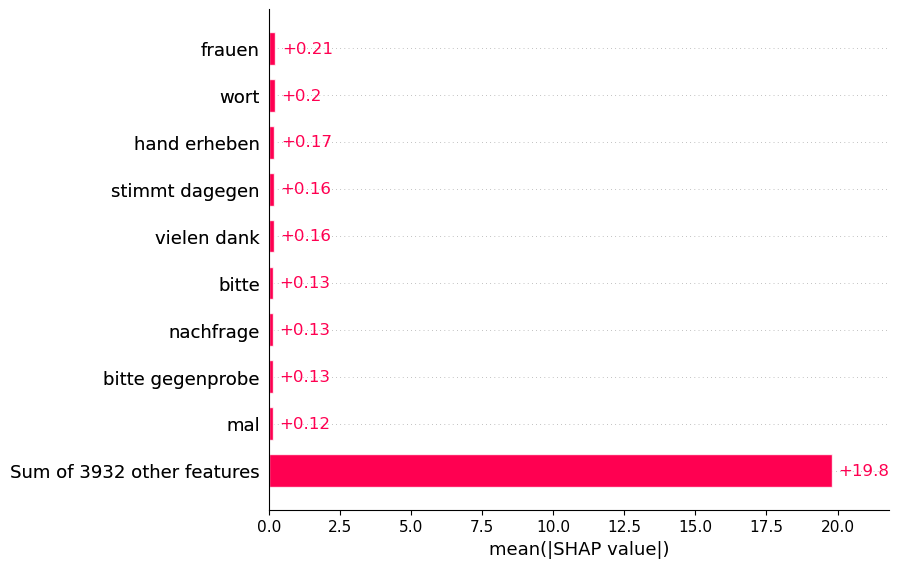

In [24]:
shap.plots.bar(shap_values)

In [26]:
coefficients = log.coef_[0]
len(coefficients)

3941

In [50]:
top_negative_features = np.argsort(coefficients)[::1][:20]
top_negative_features # female

array([ 807, 2703, 2498,  874, 2499,   68, 3125, 2575,   51, 3822, 1523,
         65, 3807, 2927, 3252, 2899,   70, 2092,   50, 2934], dtype=int64)

In [51]:
top_positive_features = np.argsort(coefficients)[::-1][:20]
top_positive_features # male

array([1896, 3847, 3720,  206,  769, 2783,  873, 2065, 3110,  666, 3331,
       1857, 2882, 1010, 1546, 2861,  708,   35, 3594, 1437], dtype=int64)

In [53]:
coefficients[1896]

1.7630534516009635

In [56]:
vec.get_feature_names_out()[top_positive_features] # male

array(['herrn berichterstatter', 'zweckmäßig', 'wort gewünscht', 'ampel',
       'bitte gegenprobe', 'renner', 'dank nächster', 'jawohl',
       'stimmt dagegen', 'besprechung', 'verehrten', 'hand erheben',
       'schmitt', 'drucksache nr', 'geehrte geehrte', 'schlage',
       'betreffend', '1962', 'wehner', 'fragen geschäftsbereich'],
      dtype=object)

In [57]:
vec.get_feature_names_out()[top_negative_features] # female

array(['bundeskanzlerin', 'präsident liebe', 'nachfrage',
       'dank präsident', 'nachfragen', '2010', 'ströbele', 'nächster',
       '1996', 'zusatzfrage rufe', 'ge', '2007', 'zurzeit', 'schäuble',
       'unionsfraktion', 'schriftliche', '2012', 'jäger', '1995',
       'seehofer'], dtype=object)

In [ ]:
# plot
for gender in ['male, female']:
    features = top_positive_features if gender=='male' else top_negative_features
    color = 'skyblue' if gender=='male' else 'orange'

    y_labels = vec.get_feature_names_out()[features]
    y_values = coefficients[features]


    plt.figure(figsize=(16, 10))
    bar = plt.barh(list(y_labels), list(y_values), color=color)
    plt.title(f'Top 20 Important Features for {gender.capitalize()} Predicitions')
    plt.bar_label(bar, label_type='edge', fmt='{:0.3f}')